In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.cluster import Decahedron
from abtem import *
import time
import cupy as cp

In [2]:
from cupy.fft.config import get_plan_cache
cache = get_plan_cache()
cache.set_size(0)

In [2]:
abtem_timings = {}

gpts = (4096, 2048, 1024, 512)
p = (27, 13, 6, 2)
interpolation = (16, 8, 4, 2)
extent = (136, 68, 34, 17)
num_fp = (1, 2, 4, 8)

for device in ('cpu','gpu'):
    abtem_timings[device] = {}
    
    for i in range(0,4):
        atoms = Decahedron('Au', p[i], 1, 1, latticeconstant=None)
        atoms.rotate(30, 'x', center='cop')

        atoms.cell[0,0] = extent[i]
        atoms.cell[1,1] = extent[i]
        atoms.center()

        atoms.center(vacuum=2, axis=2)
        
        fp = FrozenPhonons(atoms, num_fp[i], {'Au':.12})
        
        potential = Potential(fp, slice_thickness = 1, device=device, 
                              precalculate=False, projection='infinite', parametrization='kirkland')

        potential.gpts = gpts[i]

        S = SMatrix(energy=80e3, expansion_cutoff=25, semiangle_cutoff=25, interpolation=interpolation[i], device=device, storage='cpu')

        S.extent = potential.extent
        S.gpts = potential.gpts

        scan = GridScan((0,0), potential.extent, sampling=S.ctf.nyquist_sampling)

        detector = AnnularDetector(40, 120)

        start = time.time()
        measurements = S.scan(scan, detector, potential, max_batch_probes = 1024)
        end = time.time()

        abtem_timings[device][gpts[i]] = (end-start) / num_fp[i]
        
        cache = cp.fft.config.get_plan_cache()
        cache.clear() 

In [12]:
prismatic_timings = {'gpu': {2048: 23.9, 1024: 5.667, 512: 1.9},
                     'cpu': {2048: 419, 1024: 61, 512: 9.3},}

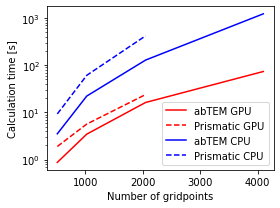

In [15]:
abtem_gpu = sorted(abtem_timings['gpu'].values())
prismatic_gpu = sorted(prismatic_timings['gpu'].values())
abtem_cpu = sorted(abtem_timings['cpu'].values())
prismatic_cpu = sorted(prismatic_timings['cpu'].values())

plt.figure(figsize=(4,3))
plt.semilogy(gpts[::-1],abtem_gpu,'r-',label='abTEM GPU')
plt.semilogy(gpts[::-1][:-1],prismatic_gpu,'r--',label='Prismatic GPU')
plt.semilogy(gpts[::-1],abtem_cpu,'b-',label='abTEM CPU')
plt.semilogy(gpts[::-1][:-1],prismatic_cpu,'b--',label='Prismatic CPU')
plt.xlabel('Number of gridpoints')
plt.ylabel('Calculation time [s]')
plt.legend()
plt.tight_layout()
#plt.savefig('performance.pdf')